In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Processed images saved in /kaggle/working/processed_images
CSV report saved at: /kaggle/working/processed_images/infection_report.csv


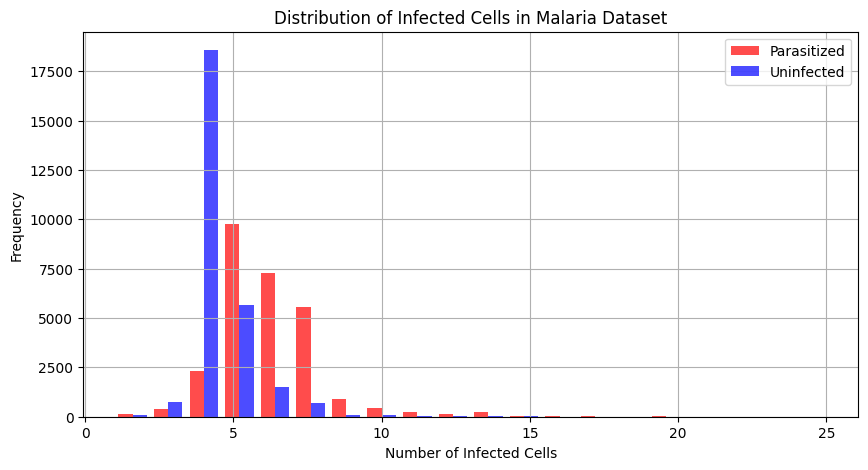

Visualization saved at: /kaggle/working/processed_images/infection_distribution.png


In [19]:
import cv2
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define input and output directories
dataset_folder = "/kaggle/input/cell-images-for-detecting-malaria/cell_images"
output_folder = "/kaggle/working/processed_images"
os.makedirs(output_folder, exist_ok=True)

# Get all image file paths
image_files = glob.glob(dataset_folder + "/**/*.png", recursive=True)

# List to store image analysis data
data = []

# Step 1: Process each image
for img_path in image_files:
    # Load the image and resize it to 224x224
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Step 2: Apply thresholding to highlight infected areas
    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
    
    # Step 3: Find contours (possible infected regions)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Step 4: Determine if the image is Parasitized or Uninfected
    label = "Parasitized" if "Parasitized" in img_path else "Uninfected"
    
    # Step 5: Draw circles around detected infected cells in ordinal order
    count = 0
    sorted_contours = sorted(contours, key=lambda c: cv2.contourArea(c), reverse=True)
    for i, contour in enumerate(sorted_contours, start=1):
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(radius)
        
        # Filter out small noise
        if radius > 5:
            count += 1
            cv2.circle(img, center, radius, (0, 0, 255), 3)  # Green circle for better visibility
            cv2.putText(img, str(count), (center[0] - 10, center[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    
    # Step 6: Store image data for CSV report
    data.append([os.path.basename(img_path), label, count])
    
    # Step 7: Display cell count on image
    cv2.putText(img, f"Infected Cells: {count}", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
    # Step 8: Save processed image
    output_path = os.path.join(output_folder, os.path.basename(img_path))
    cv2.imwrite(output_path, img)
    
    # Free memory
    del img, gray, thresh

# Step 9: Save analysis results to CSV
csv_path = os.path.join(output_folder, "infection_report.csv")
df = pd.DataFrame(data, columns=["image_name", "label", "infected_cell_count"])
df.to_csv(csv_path, index=False)

print(f"Processed images saved in {output_folder}")
print(f"CSV report saved at: {csv_path}")

# Step 10: Visualize the distribution of infected cells
plt.figure(figsize=(10, 5))
parasitized_counts = df[df['label'] == 'Parasitized']['infected_cell_count']
uninfected_counts = df[df['label'] == 'Uninfected']['infected_cell_count']

plt.hist([parasitized_counts, uninfected_counts], bins=20, label=['Parasitized', 'Uninfected'], color=['red', 'blue'], alpha=0.7)
plt.xlabel('Number of Infected Cells')
plt.ylabel('Frequency')
plt.title('Distribution of Infected Cells in Malaria Dataset')
plt.legend()
plt.grid(True)

# Step 11: Save and display the visualization
plot_path = os.path.join(output_folder, "infection_distribution.png")
plt.savefig(plot_path)
plt.show()

print(f"Visualization saved at: {plot_path}")


In [4]:
import shutil
shutil.make_archive("/kaggle/working/processed_images", 'zip', "/kaggle/working/processed_images")


'/kaggle/working/processed_images.zip'

In [5]:
# Step 12: Zip the processed images for downloading
zip_path = "/kaggle/working/processed_images.zip"
shutil.make_archive(zip_path.replace(".zip", ""), 'zip', output_folder)
print(f"Download the processed images here: {zip_path}")

Download the processed images here: /kaggle/working/processed_images.zip


In [21]:
# Step 13: Function to test the model on a new image and visualize the result
def test_model(image_path):
    test_img = cv2.imread(image_path)
    test_img = cv2.resize(test_img, (224, 224))
    gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
    
    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    count = 0
    sorted_contours = sorted(contours, key=lambda c: cv2.contourArea(c), reverse=True)
    for i, contour in enumerate(sorted_contours, start=1):
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(radius)
        
        if radius > 5:
            count += 1
            cv2.circle(test_img, center, radius, (0, 255, 0), 3)
            cv2.putText(test_img, str(count), (center[0] - 10, center[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    
    label = "Parasitized" if count > 0 else "Uninfected"
    cv2.putText(test_img, f"Infected Cells: {count}", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
    output_test_path = os.path.join(output_folder, "test_result.png")
    cv2.imwrite(output_test_path, test_img)
    
    # Display the test result
    plt.figure(figsize=(6,6))
    test_img_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    plt.imshow(test_img_rgb)
    plt.title(f"{label} - Infected Cells: {count}")
    plt.axis("off")
    plt.show()
    
    print(f"Test result saved at: {output_test_path}")
    return label, count


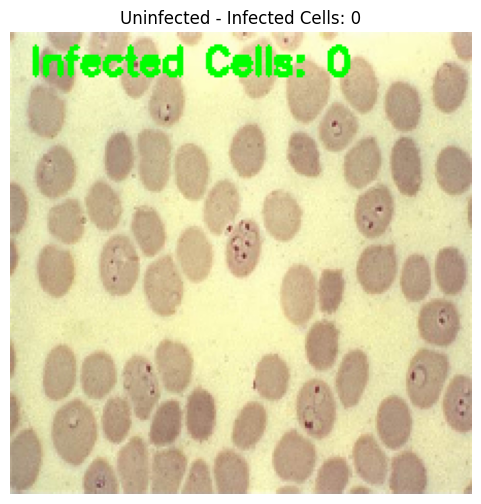

Test result saved at: /kaggle/working/processed_images/test_result.png
Test Image Classification: Uninfected, Infected Cells Detected: 0


In [24]:
# Example Usage (Uncomment to test)
test_image_path = "/kaggle/input/test-data1/OIP.jpeg"
label, cell_count = test_model(test_image_path)
print(f"Test Image Classification: {label}, Infected Cells Detected: {cell_count}")


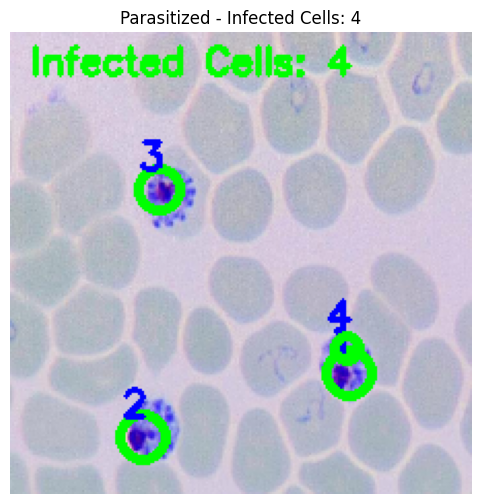

Test result saved at: /kaggle/working/processed_images/test_result.png
Test Image Classification: Parasitized, Infected Cells Detected: 4


In [23]:
# Example Usage (Uncomment to test)
test_image_path = "/kaggle/input/test-data1/161295_web.jpg"
label, cell_count = test_model(test_image_path)
print(f"Test Image Classification: {label}, Infected Cells Detected: {cell_count}")


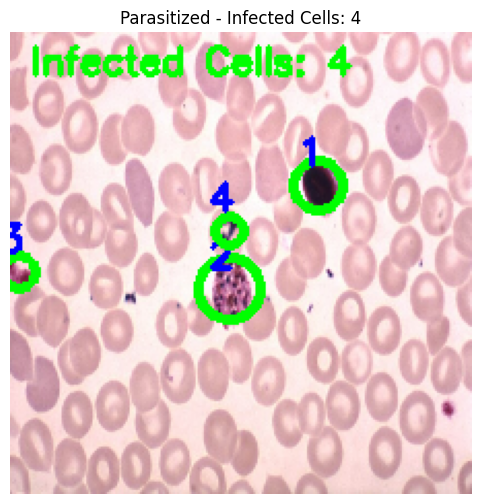

Test result saved at: /kaggle/working/processed_images/test_result.png
Test Image Classification: Parasitized, Infected Cells Detected: 4


In [22]:
# Example Usage (Uncomment to test)
test_image_path = "/kaggle/input/test-data/iamm.jpg"
label, cell_count = test_model(test_image_path)
print(f"Test Image Classification: {label}, Infected Cells Detected: {cell_count}")